In [69]:
import math
import csv
from scipy import integrate
import numpy as np
import matplotlib as matplotlib
import matplotlib.pyplot as plt
from cardano_method import CubicEquation

In [82]:
pi = math.pi
accuracy = 1e-16
q = 1.602176634e-19 # elementary charge
m0 = 9.1093837015e-31 # electron mass
mRel = 0.342 # b-Ga2O3 relative reduced electron mass 
m = mRel * m0 # b-Ga2O3 reduced electron mass
h = 6.62607015e-34 # Planck constant
hBar = h/2/pi
kB = 1.380649e-23 # Boltzmann constant
e0 = 8.8541878128e-12 # vacuum permittivity
eOpt = 3.57 # optical dielectric constant of b-Ga2O3
eSta = 10 # static dielectric constant of b-Ga2O3
T = 295 # device temperature
kT = kB*T 
Nc = 1e-6*2*(2*pi*m*kT/h**2)**1.5
n = 1.6e16 # sample carrier concentration in cm-3
phiM = kT*np.log(Nc/n)/q # Ec-Ef in eV  
#phi = 1 # Barrier height in eV
A = 4*pi*q*m*kB**2/h**3 # effective Richarson constant in A/m2/K2
aOpt = q/16/pi/eOpt/e0 # coefficient a (with the negative sign, optic) in front of the 1/x term of the potential a = e/(16*pi*e)
aSta = q/16/pi/eSta/e0 # coefficient a (with the negative sign, static) in front of the 1/x term of the potential a = e/(16*pi*e)
# b = 0
b = q*n*1e6/2/e0/eSta # coefficient b (V/m2) in front of the quadratic term of the potential b = q*n/2e
print (kT/q)
print(A)

0.025421133123328277
410992.4430052497


In [89]:
def fF (phiB, Vr): # surface electrical field in V/m
    return ((2*q*n*1e6*(phiB-Vr-phiM-kT/q)/eSta/e0)**0.5)
def fWd (phiB, Vr): # depletion width in nm
    return ((2/q/n/1e6*(phiB-Vr-phiM-kT/q)*eSta*e0)**0.5*1e9)
def fXmax(phiB, Vr, a): # position in nm, at which the top of the potential barrier reaches maximum  
    equation = CubicEquation([2*b*1e-18,-fF(phiB,Vr)*1e-9,0,a*1e9]) # coefficients are converted so that the solutions give results in nm
    return (equation.answers[2].real) # first solution is ~ Wd, second is ~ -xmax, and third is xmax
def fEmax(phiB, Vr, a): # top of the potential barrier in eV
    x = fXmax(phiB, Vr, a)*1e-9 # convert xmax back to m
    print('x max: ', x)
    return (phiB - fF(phiB,Vr)*x - a/x + b*x**2)
def fX1X2(W, phiB, Vr, a): # returns an array with positions x1, x2 in nm, where W and E intersect 
    # W is in V, if it is energy it would be measusred in eV
    equation = CubicEquation([b*1e-18,-fF(phiB,Vr)*1e-9,phiB-W,-a*1e9])# coefficients are converted so that the solutions give results in nm
    return ([equation.answers[1].real, equation.answers[2].real])
    #return(equation.answers)
def fIntegrand(x, W, phiB, F, a, b): # returns function that needs to be integrated, unit is V^0.5
    # x is in nanometer, W, phiB in V, F in V/m, a V*m, b in V/m2
    y = x*1e-9
    return ((phiB-W-F*y-a/y+b*y**2)**0.5)
def fProb(W, phiB, Vr, a): # returns probability of the transition of electons with energy W (in eV in this case)
    x1,x2 = fX1X2(W,phiB,Vr, a)
    F = fF(phiB, Vr)
    if W >= fEmax(phiB, Vr, a):
        result = 1
    else:
        rIntegral = integrate.quad(fIntegrand, x1, x2, args = (W, phiB, F, a, b))[0]
        #print(f"rIntegral: ", rIntegral, " x1: ", x1, " x2: ", x2, " W: ", W)
        try:
            result = 1/(1 + np.exp((8*m*q)**0.5/hBar*rIntegral*1e-9))
        except OverflowError:
            result = 0
        print(f"rIntegral: ", rIntegral, " x1: ", x1, " x2: ", x2, " W: ", W, " Prob: ", result)
    return (result)
def fDiffJ(W, phiB, Vr, a): # returns differential current density in A/cm2/eV at energy W in eV (or V)
    if (np.exp(-W*q/kT) > accuracy):
        result = A*T/kB*fProb(W, phiB, Vr, a)*np.log(1 + np.exp(-W*q/kT))*1e-4*q
    else:
        result = A*T/kB*fProb(W, phiB, Vr, a)*np.exp(-W*q/kT)*1e-4*q
    return (result)
def fJ (phiB, Vr, a): # returns current in A/cm2
    result = integrate.quad(fDiffJ, 0, np.inf, args =(phiB, Vr, a))[0]
    return (result)

In [90]:
print(fF(1,-250))
print (fXmax(1, -250,aSta))
print (fEmax(1, -250,aSta))
print(fX1X2(0.74,1,-250,aSta))
# print (fProb(0.779534664,1,-250,aOpt))
#print (fProb(0.8682702010292268-0.025,1,-250,aSta))

120516017.49354358
0.546578
x max:  5.465780000000001e-10
0.8682702010292268
[0.148709, 2.009204]


In [91]:
arrDelW = np.linspace(0.001, 0.2, 200) # array of different in eV from the top of the potential
arrProb = [(fProb(fEmax(1,-250,aSta)-delW,1,-250, aSta)) for delW in arrDelW] 

x max:  5.465780000000001e-10
x max:  5.465780000000001e-10
rIntegral:  0.0033503009352593687  x1:  0.483249  x2:  0.618207  W:  0.8672702010292268  Prob:  0.4949813047851446
x max:  5.465780000000001e-10
x max:  5.465780000000001e-10
rIntegral:  0.00671010794844193  x1:  0.459268  x2:  0.650488  W:  0.8662702010292268  Prob:  0.4899493860481101
x max:  5.465780000000001e-10
x max:  5.465780000000001e-10
rIntegral:  0.010079398740301507  x1:  0.441709  x2:  0.676346  W:  0.8652702010292268  Prob:  0.4849053090947848
x max:  5.465780000000001e-10
x max:  5.465780000000001e-10
rIntegral:  0.013458151009769862  x1:  0.427456  x2:  0.698899  W:  0.8642702010292268  Prob:  0.4798501548597381
x max:  5.465780000000001e-10
x max:  5.465780000000001e-10
rIntegral:  0.016846342833593313  x1:  0.415302  x2:  0.719353  W:  0.8632702010292268  Prob:  0.47478501849975574
x max:  5.465780000000001e-10
x max:  5.465780000000001e-10
rIntegral:  0.0202439522065182  x1:  0.404632  x2:  0.738323  W:  0.8

Text(0, 0.5, 'Transmission Probability')

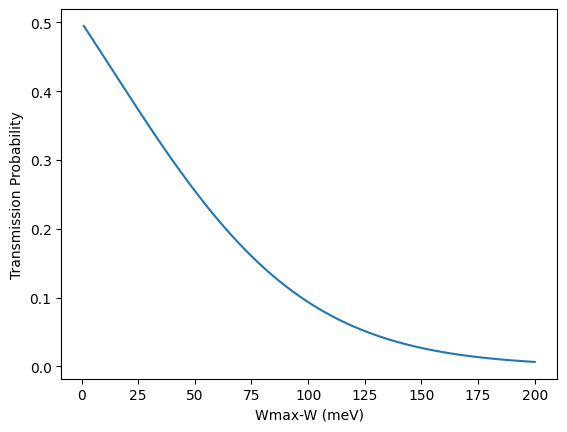

In [88]:
fig, ax = plt.subplots()
ax.plot(arrDelW*1e3, arrProb)
ax.set_yscale('linear')
plt.xlabel("Wmax-W (meV)")
plt.ylabel("Transmission Probability")

In [342]:

with open("F01BH1p10OptDC.csv", "w", newline="") as csvfile:
  # Create a csv writer object
  writer = csv.writer(csvfile)
  # Combine data using zip and write as rows
  writer.writerows(zip(arrV, arrJ))

In [353]:
print(arrJ)

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,

In [175]:
# print (A*T/kB*1e-4*q) # in A/cm2/eV
# print (math.exp(-40))
# print (math.exp(-40)*A*T/kB*1e-4*q) # in A/cm2
# print (q/kT)
# print (fProb(1, 1, 0, aSta))
# print (np.exp(-q/kT))
a = np.exp(-37)
print ("a: ", a, " log: " , np.log(1 + a))

a:  8.533047625744066e-17  log:  0.0


Text(0, 0.5, 'Current Density (A/cm2)')

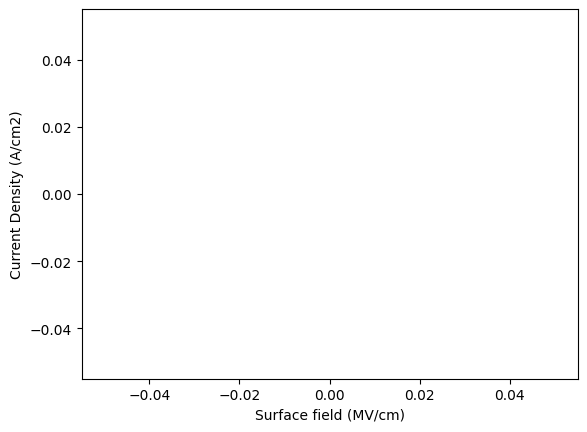

In [352]:
fig2, ax2 = plt.subplots()
ax2.plot(arrF, arrJ)
ax1.set_yscale('log')
plt.xlabel("Surface field (MV/cm)")
plt.ylabel("Current Density (A/cm2)")

In [21]:
arrW = np.linspace(0.001, 1, 1000)
arrDiffJ = [(fDiffJ(W, 1, -250, aSta)) for W in arrW]

Text(0, 0.5, 'Differential Current Density (A/cm2/eV)')

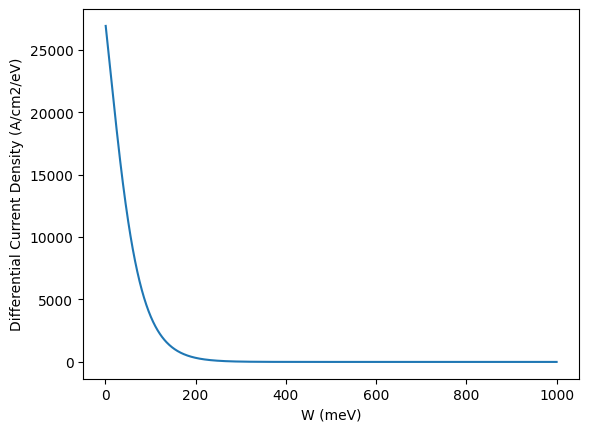

In [22]:
fig1, ax1 = plt.subplots()
ax1.plot(arrW*1e3, arrDiffJ)
ax1.set_yscale('linear')
plt.xlabel("W (meV)")
plt.ylabel("Differential Current Density (A/cm2/eV)")

In [358]:
arrV = -np.linspace(1, 4000, 4001) # array of different in eV from the top of the potential
#arrF = [(fF(1.4, V)*1e-8) for V in arrV] # in MV/cm
#arrJ = [(fJ(1.4, V, aSta)) for V in arrV] # in A/cm2 
print(fJ(1.4, -200, aSta))

nan


/tmp/ipykernel_461/2554833055.py:26: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  rIntegral = integrate.quad(fIntegrand, x1, x2, args = (W, phiB, F, a, b))[0]
/tmp/ipykernel_461/2554833055.py:40: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result = integrate.quad(fDiffJ, 0, np.inf, args =(phiB, Vr, a))[0]


In [204]:
#print (arrDiffJ)